In [1]:
from top2vec import Top2Vec

In [2]:
import pandas as pd
import numpy as np

In [3]:
from nltk.tokenize import sent_tokenize

In [118]:
import plotly.express as px
import plotly.graph_objects as go

In [4]:
from tqdm.auto import tqdm

In [6]:
tqdm.pandas()

In [7]:
df = pd.read_csv('./manifesto_articles_preprocessed.csv').rename({'index':'id_fichier'},axis=1)

In [8]:
manifestos = df[~df.partyname.isin(["Le Monde", "Le Figaro"])].reset_index(drop=True)

In [9]:
articles = df[df.partyname.isin(["Le Monde", "Le Figaro"])].reset_index(drop=True)

In [10]:
manifestos = manifestos.reset_index().rename({'index':'id_manifesto'},axis=1)

In [11]:
dict_party = {'Socialist Party':'PS',
              'Europe Ecology - The Greens':'EELV',
              'The Republicans':'RPR/UMP/LR',
              'National Front':'FN',
              'Democratic Movement':'MoDem/EM',
              'Republic Onwards!':'MoDem/EM',
              'Left Front':'PCF/PG/LFI',
              'Indomitable France':'PCF/PG/LFI',
              'French Communist Party':'PCF/PG/LFI'}

In [12]:
manifestos.partyname = manifestos.partyname.apply(lambda x: dict_party[x])

In [13]:
articles = articles.reset_index().rename({'index':'id_article'},axis=1)

In [14]:
manifestos['sents'] = manifestos.text.apply(lambda x: sent_tokenize(x,language='french'))

In [15]:
manifestos['sents'] = manifestos.apply(lambda row: [[row['id_manifesto'], sent] for sent in row['sents']], axis=1)

In [254]:
manifesto_sents = pd.DataFrame([a for b in manifestos.sents for a in b])

In [255]:
manifesto_sents.columns = ['id_manifesto','sent']

In [257]:
manifesto_sents = pd.merge(manifesto_sents, manifestos[['id_manifesto','partyname','annee']], on='id_manifesto',how='left')

In [18]:
len(manifesto_sents.sent.tolist())

16334

In [318]:
manifestos.words = manifestos.words.progress_apply(eval).progress_apply(lambda x: [a for a in x if a not in ["→","”","“"]])

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [319]:
manifestos['chunks'] = manifestos.apply(lambda row: [[row['id_manifesto'], row['words'][x:x+100]] for x in range(0, len(row['words']), 100)], axis=1)

In [985]:
chunks_manifesto = pd.DataFrame([a for b in manifestos.chunks for a in b])
chunks_manifesto.columns = ['id_manifesto','words']

In [986]:
chunks_manifesto['text'] = chunks_manifesto.words.apply(lambda x: " ".join(x))

In [987]:
chunks_manifesto = pd.merge(chunks_manifesto, manifestos[['id_manifesto','partyname','annee']])

In [37]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

In [50]:
""" Overwrite the constructor of the Top2Vec for reproducibility by adding the parameter random_state.

Its value is used to set the parameters seed in Doc2Vec and random_state in umap.    

Note that for a fully deterministically-reproducible run, you must also limit the model 
to a single worker thread (workers=1), to eliminate ordering jitter from OS thread scheduling. 
"""




import logging
import numpy as np
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags
import umap
import hdbscan
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.cluster import dbscan
import tempfile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.special import softmax

try:
    import hnswlib

    _HAVE_HNSWLIB = True
except ImportError:
    _HAVE_HNSWLIB = False

try:
    import tensorflow as tf
    import tensorflow_hub as hub
    import tensorflow_text

    _HAVE_TENSORFLOW = True
except ImportError:
    _HAVE_TENSORFLOW = False

try:
    from sentence_transformers import SentenceTransformer

    _HAVE_TORCH = True
except ImportError:
    _HAVE_TORCH = False

logger = logging.getLogger('top2vec')
logger.setLevel(logging.WARNING)
sh = logging.StreamHandler()
sh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.addHandler(sh)

def default_tokenizer(doc):
    """Tokenize documents for training and remove too long/short words"""
    return simple_preprocess(strip_tags(doc), deacc=True)

class Top2Vec_rep(Top2Vec):
    def __init__(self,
                 documents,
                 min_count=50,
                 embedding_model='doc2vec',
                 embedding_model_path=None,
                 speed='learn',
                 use_corpus_file=False,
                 document_ids=None,
                 keep_documents=True,
                 workers=None,
                 tokenizer=None,
                 use_embedding_model_tokenizer=False,
                 umap_args=None,
                 hdbscan_args=None,
                 verbose=True,
                 random_state=42
                 ):

        if verbose:
            logger.setLevel(logging.DEBUG)
            self.verbose = True
        else:
            logger.setLevel(logging.WARNING)
            self.verbose = False

        if tokenizer is None:
            tokenizer = default_tokenizer

        # validate documents
        if not (isinstance(documents, list) or isinstance(documents, np.ndarray)):
            raise ValueError("Documents need to be a list of strings")
        if not all((isinstance(doc, str) or isinstance(doc, np.str_)) for doc in documents):
            raise ValueError("Documents need to be a list of strings")
        if keep_documents:
            self.documents = np.array(documents, dtype="object")
        else:
            self.documents = None

        # validate document ids
        if document_ids is not None:
            if not (isinstance(document_ids, list) or isinstance(document_ids, np.ndarray)):
                raise ValueError("Documents ids need to be a list of str or int")

            if len(documents) != len(document_ids):
                raise ValueError("Document ids need to match number of documents")
            elif len(document_ids) != len(set(document_ids)):
                raise ValueError("Document ids need to be unique")

            if all((isinstance(doc_id, str) or isinstance(doc_id, np.str_)) for doc_id in document_ids):
                self.doc_id_type = np.str_
            elif all((isinstance(doc_id, int) or isinstance(doc_id, np.int_)) for doc_id in document_ids):
                self.doc_id_type = np.int_
            else:
                raise ValueError("Document ids need to be str or int")

            self.document_ids_provided = True
            self.document_ids = np.array(document_ids)
            self.doc_id2index = dict(zip(document_ids, list(range(0, len(document_ids)))))
        else:
            self.document_ids_provided = False
            self.document_ids = np.array(range(0, len(documents)))
            self.doc_id2index = dict(zip(self.document_ids, list(range(0, len(self.document_ids)))))
            self.doc_id_type = np.int_

        acceptable_embedding_models = ["universal-sentence-encoder-multilingual",
                                       "universal-sentence-encoder",
                                       "distiluse-base-multilingual-cased"]

        self.embedding_model_path = embedding_model_path

        if embedding_model == 'doc2vec':

            # validate training inputs
            if speed == "fast-learn":
                hs = 0
                negative = 5
                epochs = 40
            elif speed == "learn":
                hs = 1
                negative = 0
                epochs = 40
            elif speed == "deep-learn":
                hs = 1
                negative = 0
                epochs = 400
            elif speed == "test-learn":
                hs = 0
                negative = 5
                epochs = 1
            else:
                raise ValueError("speed parameter needs to be one of: fast-learn, learn or deep-learn")

            if workers is None:
                pass
            elif isinstance(workers, int):
                pass
            else:
                raise ValueError("workers needs to be an int")

            doc2vec_args = {"vector_size": 300,
                            "min_count": min_count,
                            "window": 15,
                            "sample": 1e-5,
                            "negative": negative,
                            "hs": hs,
                            "epochs": epochs,
                            "dm": 0,
                            "dbow_words": 1,
                            "seed": random_state}

            if workers is not None:
                doc2vec_args["workers"] = workers

            logger.info('Pre-processing documents for training')

            if use_corpus_file:
                processed = [' '.join(tokenizer(doc)) for doc in documents]
                lines = "\n".join(processed)
                temp = tempfile.NamedTemporaryFile(mode='w+t')
                temp.write(lines)
                doc2vec_args["corpus_file"] = temp.name


            else:
                train_corpus = [TaggedDocument(tokenizer(doc), [i]) for i, doc in enumerate(documents)]
                doc2vec_args["documents"] = train_corpus

            logger.info('Creating joint document/word embedding')
            self.embedding_model = 'doc2vec'
            self.model = Doc2Vec(**doc2vec_args)

            if use_corpus_file:
                temp.close()

        elif embedding_model in acceptable_embedding_models:

            self.embed = None
            self.embedding_model = embedding_model

            self._check_import_status()

            logger.info('Pre-processing documents for training')

            # preprocess documents
            tokenized_corpus = [tokenizer(doc) for doc in documents]

            def return_doc(doc):
                return doc

            # preprocess vocabulary
            vectorizer = CountVectorizer(tokenizer=return_doc, preprocessor=return_doc)
            doc_word_counts = vectorizer.fit_transform(tokenized_corpus)
            words = vectorizer.get_feature_names()
            word_counts = np.array(np.sum(doc_word_counts, axis=0).tolist()[0])
            vocab_inds = np.where(word_counts > min_count)[0]

            if len(vocab_inds) == 0:
                raise ValueError(f"A min_count of {min_count} results in "
                                 f"all words being ignored, choose a lower value.")
            self.vocab = [words[ind] for ind in vocab_inds]

            self._check_model_status()

            logger.info('Creating joint document/word embedding')

            # embed words
            self.word_indexes = dict(zip(self.vocab, range(len(self.vocab))))
            self.word_vectors = self._l2_normalize(np.array(self.embed(self.vocab)))

            # embed documents
            if use_embedding_model_tokenizer:
                self.document_vectors = self._embed_documents(documents)
            else:
                train_corpus = [' '.join(tokens) for tokens in tokenized_corpus]
                self.document_vectors = self._embed_documents(train_corpus)

        else:
            raise ValueError(f"{embedding_model} is an invalid embedding model.")

        # create 5D embeddings of documents
        logger.info('Creating lower dimension embedding of documents')

        if umap_args is None:
            umap_args = {'n_neighbors': 15,
                         'n_components': 5,
                         'metric': 'cosine',
                         'random_state':random_state}

        umap_model = umap.UMAP(**umap_args).fit(self._get_document_vectors(norm=False))

        # find dense areas of document vectors
        logger.info('Finding dense areas of documents')

        if hdbscan_args is None:
            hdbscan_args = {'min_cluster_size': 15,
                            'metric': 'euclidean',
                            'cluster_selection_method': 'eom'}

        cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_model.embedding_)

        # calculate topic vectors from dense areas of documents
        logger.info('Finding topics')

        # create topic vectors
        self._create_topic_vectors(cluster.labels_)

        # deduplicate topics
        self._deduplicate_topics()

        # find topic words and scores
        self.topic_words, self.topic_word_scores = self._find_topic_words_and_scores(topic_vectors=self.topic_vectors)

        # assign documents to topic
        self.doc_top, self.doc_dist = self._calculate_documents_topic(self.topic_vectors,
                                                                      self._get_document_vectors())

        # calculate topic sizes
        self.topic_sizes = self._calculate_topic_sizes(hierarchy=False)

        # re-order topics
        self._reorder_topics(hierarchy=False)

        # initialize variables for hierarchical topic reduction
        self.topic_vectors_reduced = None
        self.doc_top_reduced = None
        self.doc_dist_reduced = None
        self.topic_sizes_reduced = None
        self.topic_words_reduced = None
        self.topic_word_scores_reduced = None
        self.hierarchy = None

        # initialize document indexing variables
        self.document_index = None
        self.serialized_document_index = None
        self.documents_indexed = False
        self.index_id2doc_id = None
        self.doc_id2index_id = None

        # initialize word indexing variables
        self.word_index = None
        self.serialized_word_index = None
        self.words_indexed = False

In [550]:
d2vmodel = Top2Vec_rep(documents=manifesto_sents.sent.tolist(),
                    embedding_model='doc2vec', #universal-sentence-encoder-multilingual, distiluse-base-multilingual-cased
                    speed="learn",
                    #min_count=0,
                    #use_embedding_model_tokenizer=True,
                    workers=1,
                    random_state=2021)

2021-12-06 14:10:25,863 - top2vec - INFO - Pre-processing documents for training
2021-12-06 14:10:25,863 - top2vec - INFO - Pre-processing documents for training
2021-12-06 14:10:25,863 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-12-06 14:10:27,282 - top2vec - INFO - Creating joint document/word embedding
2021-12-06 14:10:27,282 - top2vec - INFO - Creating joint document/word embedding
2021-12-06 14:10:27,282 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-12-06 14:10:52,216 - top2vec - INFO - Creating lower dimension embedding of documents
2021-12-06 14:10:52,216 - top2vec - INFO - Creating lower dimension embedding of documents
2021-12-06 14:10:52,216 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-12-06 14:11:06,591 - top2vec - INFO - Finding dense areas of document

In [555]:
documents, document_scores, document_ids = d2vmodel.search_documents_by_keywords(keywords=["immigration"], num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 6655, Score: 0.7180104851722717
-----------
Sous couvert de lutter contre un “racisme” totalement inexistant en France, comme en témoignent les statistiques de la Commission nationale consultative des droits de l’homme, c’est en réalité au droit des Français à rester maîtres chez eux que s’en prennent ces législations.
-----------

Document: 4094, Score: 0.709083080291748
-----------
Il est vrai que la plupart d’entre eux considèrent que la France n’a pas à avoir d’avenir puisqu’elle n’a plus de raison d’exister.
-----------

Document: 10341, Score: 0.7069998979568481
-----------
Il faut proposer à nos partenaires européens une mesure de bon sens : adopter un accord institutionnel reprenant les avancées institutionnelles du projet de Constitution qui n’ont été contestées par personne pendant la campagne référendaire et qui seules permettront à l’Europe élargie de fonctionner de nouveau : la Présidence stable de l’Union, le ministre des affaires étrangères, l’extension de la m

In [594]:
chunks_manifesto[['partyname','annee']].value_counts()

partyname   annee
FN          2007     350
EELV        2007     144
RPR/UMP/LR  2007     141
FN          2002     125
EELV        2012     108
PCF/PG/LFI  2017      74
MoDem/EM    2002      73
            2007      73
PCF/PG/LFI  2012      66
PS          2007      58
PCF/PG/LFI  2007      50
RPR/UMP/LR  2012      40
MoDem/EM    2012      36
FN          2012      23
PS          2002      23
FN          2017      21
MoDem/EM    2017      19
RPR/UMP/LR  2017      17
PS          2012      16
EELV        2017      13
            2002      13
RPR/UMP/LR  2002      10
PS          2017       6
dtype: int64

In [888]:
model = Top2Vec_rep(documents=chunks_manifesto.text.tolist(),
                    embedding_model='universal-sentence-encoder-multilingual', #universal-sentence-encoder-multilingual, distiluse-base-multilingual-cased
                    speed="learn",
                    #min_count=0,
                    use_embedding_model_tokenizer=True,
                    workers=1,
                    random_state=2021)

2021-12-06 16:19:04,001 - top2vec - INFO - Pre-processing documents for training
2021-12-06 16:19:04,001 - top2vec - INFO - Pre-processing documents for training
2021-12-06 16:19:04,001 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-12-06 16:19:04,990 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2021-12-06 16:19:04,990 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
2021-12-06 16:19:04,990 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-12-06 16:19:13,303 - top2vec - INFO - Creating joint document/word embedding
2021-12-06 16:19:13,303 - top2vec - INFO - Creating joint document/word embedding
2021-12-06 16:19:13,303 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-12-06 16:19:38,742 - top2vec 

In [889]:
model.get_num_topics()

22

In [890]:
umap_args = {'n_neighbors': 15,
             'n_components': 5,
             'metric': 'cosine',
             'random_state':2021}

umap_model = umap.UMAP(**umap_args).fit(model._get_document_vectors(norm=False))

hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_model.embedding_)

In [809]:
len(cluster.labels_==-1)

1499

In [891]:
dict_topic = {i:model.topic_words[i][0] for i in range(model.get_num_topics())}

In [893]:
umap_2d = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine",random_state=2021).fit(model._get_document_vectors(norm=False))

In [903]:
topic_embed = umap_2d.transform(model.topic_vectors)

umap_embed = pd.DataFrame(umap_2d.embedding_)

umap_embed['topic'] = model.doc_top
umap_embed['topic'] = umap_embed['topic'].astype('object')

#umap_embed = pd.concat([umap_embed,manifesto_sents[['partyname','annee']]],axis=1)
umap_embed = pd.concat([umap_embed,chunks_manifesto[['partyname','annee']]],axis=1)

umap_embed['party_year'] = umap_embed.partyname + '_' + umap_embed.annee.apply(str)

umap_embed['topic_name'] = umap_embed['topic'].apply(lambda x: dict_topic[x])

In [914]:
umap_embed['cluster_label'] = cluster.labels_
umap_embed['cluster_label'] = umap_embed['cluster_label'].astype('object')

In [955]:
#remove noises

umap_embed = umap_embed[umap_embed['cluster_label']!=-1]

In [956]:
umap_by_manifesto = umap_embed[[0,1,'partyname','annee']].groupby(['partyname','annee']).mean().reset_index()
umap_by_manifesto['party_year'] = umap_by_manifesto.partyname + '_' + umap_by_manifesto.annee.apply(str)

In [991]:
dict_cluster={-1:'noise', 0:'logement',1:'scolaire',2:'culturel',3:'judiciaire',4:'maritime',5:'public',6:'medical',7:'citoyennete',8:'social',9:'familial',10:'regional',11:'parlement',12:'immigration',13:'discrimination',14:'agriculture',15:'environnemental',16:'energie',17:'emploie',18:'fiscal',19:'militaire',20:'europeen',21:'mondialisation'}

In [941]:
fig = px.scatter(umap_embed,x=0,y=1,color='cluster_label',
                 hover_data=['topic_name'],
                 #color_discrete_map=dict_color,
                 color_discrete_sequence=px.colors.qualitative.Light24
                )

fig.add_traces(go.Scatter(
            x=topic_embed[:,0], y=topic_embed[:,1],
            text=list(dict_topic.values()),
            mode="markers+text",
            name='topic vector',
            marker=dict(symbol='star', size=15),
            textfont=dict(
            family="sans serif",
            size=20,
            color="Black"))
               
                  )

In [968]:
fig = px.scatter(umap_embed,x=0,y=1,color='partyname',
                 color_discrete_map=dict_color,
                 #color_discrete_sequence=px.colors.qualitative.Light24
                )

fig.add_traces(go.Scatter(
            x=topic_embed[:,0], y=topic_embed[:,1],
            text=list(dict_topic.values()),
            mode="markers+text",
            name='topic vector',
            marker=dict(symbol='star', size=15),
            textfont=dict(
            family="sans serif",
            size=20,
            color="Black"))
               
                  )

In [812]:
for i in range(model.get_num_topics()):
    print('---')
    print(f'Topic {i}')
    print('---')
    print(", ".join(model.topic_words[i]))


---
Topic 0
---
emploi, chomage, travailleur, salarier, employeur, salarie, salaire, precarite, remuneration, travail, fonctionnaire, syndical, retraite, economie, pension, syndicat, qualification, secteur, economique, social, societe, personnel, discrimination, entreprise, revenu, recrutement, effectif, republicain, profession, contrat, prestation, cotisation, reform, politique, republique, population, collective, statut, regroupement, reforme, droit, immigration, jeune, socialiste, existence, chercheur, augmentation, unique, reduction, penal
---
Topic 1
---
scolaire, education, enseignement, pedagogique, college, universite, enseignant, qualification, ecole, universitaire, educatif, classe, institution, republicain, nation, etudiant, primaire, republique, militaire, salaire, principal, formation, exigence, salarie, reforme, fonctionnaire, cours, reform, salarier, precarite, ressortissant, apprentissage, nationalite, quartier, citoyennete, national, cotisation, integration, remunerati

In [988]:
chunks_manifesto['topic'] = model.doc_top

In [989]:
chunks_manifesto['cluster'] = cluster.labels_

In [942]:
#chunks_manifesto = chunks_manifesto[chunks_manifesto['cluster_label']!=-1]

In [993]:
chunks_manifesto['topic_name'] = chunks_manifesto['cluster'].apply(lambda x: dict_cluster[x])

In [ ]:
chunks_manifesto.groupby('cluster').apply(lambda df: (df.id_manifesto.value_counts()/chunks_manifesto.id_manifesto.value_counts()).fillna(0).tolist())

In [1034]:
# topic distribution: quel pourcentage de chaque manifesto a contribué à la construction de chaque cluster

topic_distribution = chunks_manifesto.groupby('cluster').apply(lambda df: (df.id_manifesto.value_counts()/chunks_manifesto.id_manifesto.value_counts()).fillna(0).tolist())

In [1035]:
manifesto_topic = manifestos[['id_manifesto','partyname','annee']]

In [1040]:
topic_distribution = topic_distribution.drop(-1)

In [1074]:
chunks_manifesto[chunks_manifesto['cluster']==12].id_manifesto.value_counts(normalize=True)

5     0.352941
4     0.147059
10    0.117647
6     0.058824
9     0.058824
18    0.058824
7     0.029412
8     0.029412
12    0.029412
15    0.029412
16    0.029412
21    0.029412
22    0.029412
Name: id_manifesto, dtype: float64

In [1071]:
np.transpose(topic_distribution.tolist())[:,12]

array([0.        , 0.        , 0.        , 0.        , 0.04      ,
       0.03428571, 0.01388889, 0.01369863, 0.02      , 0.03448276,
       0.02836879, 0.        , 0.00925926, 0.        , 0.        ,
       0.025     , 0.04347826, 0.        , 0.02702703, 0.        ,
       0.        , 0.05882353, 0.04761905])

In [1049]:
manifesto_topic['topic_distribution'] = np.transpose(topic_distribution.tolist()).tolist()

<ipython-input-1049-9d8823896d93>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [1052]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

def add_correlation_circle(figure, coeffs, texts, normalization=True, add_circle=True):
    if add_circle:
        figure.add_shape(type="circle",
                         xref="x", yref="y",
                         x0=-1, y0=-1, x1=1, y1=1,
                         line_color="blue"
                        )
    if normalization:
        coeffs = normalize(coeffs,axis=0)
    for i in range(coeffs.shape[1]):
        figure.add_annotation(
            x=coeffs[0,i],  # arrows' head
            y=coeffs[1,i],  # arrows' head
            ax=0,  # arrows' tail
            ay=0,  # arrows' tail
            xref='x',
            yref='y',
            axref='x',
            ayref='y',
            text='',  # if you want only the arrow
            showarrow=False,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=2,
            arrowcolor='red'
        )

        figure.add_annotation(
            x=coeffs[0,i]*1.25, 
            y=coeffs[1,i]*1.25,
            text=texts[i],
            showarrow=False,
            font=dict(size=10,color="red")
        )
    return figure

In [1053]:
data = manifesto_topic.topic_distribution.to_list()

In [1054]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [1056]:
pca = PCA()
pca.fit(data)

PCA()

In [1057]:
px.line(pca.explained_variance_ratio_, labels={'index':'Principal Component','value':'Explained Variance Ratio'})

In [1058]:
comp = pca.components_[[0,1],:]

In [1059]:
pca_manifesto = pd.DataFrame(pca.transform(data)[:, [0,1]])

In [1060]:
pca_manifesto = pd.concat([pca_manifesto,manifesto_topic[['partyname','annee']]],axis=1)
pca_manifesto['annee'] = pca_manifesto['annee'].astype('object')
#pca_manifesto = pca_manifesto.drop(0)
pca_manifesto['name_year'] = pca_manifesto['partyname'] + '_' +pca_manifesto['annee'].apply(str)

In [701]:
dict_color = {'PS': 'pink', 
              'MoDem/EM': 'orange', 
              'RPR/UMP/LR': 'blue',
              'FN':'darkslateblue',
              'EELV':'green',
              'PCF/PG/LFI':'red',
              'Le Monde':'black',
              'Le Figaro':'cyan'}

In [710]:
#pca_manifesto = pca_manifesto.drop([16])

In [1063]:
fig = px.scatter(pca_manifesto, x=0, y=1, color='partyname', text='name_year', 
                 color_discrete_map=dict_color,
#                 labels={"0":"PC 1", "1":"PC 2"},
#                 range_x=[-5,5], range_y=[-5,5],
#                 height=1000, width=1200
                )

fig.show()

In [340]:
import umap

In [341]:
import umap.plot

In [883]:
fig = px.scatter(umap_embed,x=0,y=1,color='topic_name',hover_data=['topic'],
                 color_discrete_sequence=px.colors.qualitative.Light24
                )

fig.add_traces(go.Scatter(
            x=topic_embed[:,0], y=topic_embed[:,1],
            text=model.topic_words[:,0],
            mode="markers+text",
            textfont=dict(
            family="sans serif",
            size=20,
            color="Black"))
               
                  )

In [724]:
umap_embed

,0,1,topic,partyname,annee,party_year,topic_name
0,8.151793,4.497937,3,EELV,2002,EELV_2002,citoyennete
1,8.049961,4.450078,3,EELV,2002,EELV_2002,citoyennete
2,5.184878,3.159429,11,EELV,2002,EELV_2002,mondialisation
3,6.383236,5.849808,5,EELV,2002,EELV_2002,fiscal
4,6.304251,7.085637,0,EELV,2002,EELV_2002,emploi
...,...,...,...,...,...,...,...
1494,10.976411,0.137974,12,FN,2017,FN_2017,culturel
1495,4.070445,1.698110,14,FN,2017,FN_2017,militaire
1496,2.518365,5.420586,2,FN,2017,FN_2017,agriculture
1497,2.440959,5.332715,2,FN,2017,FN_2017,agriculture


<AxesSubplot:>

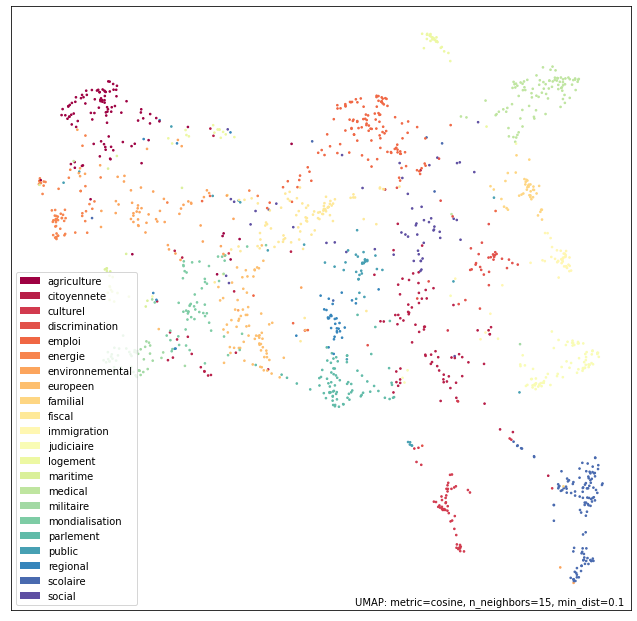

In [547]:
umap.plot.points(umap_model, labels=umap_embed['topic_name'])

In [726]:
umap_args = {'n_neighbors': 15,
             'n_components': 5,
             'metric': 'cosine',
             'random_state':2021}

umap_model = umap.UMAP(**umap_args).fit(model._get_document_vectors(norm=False))

hdbscan_args = {'min_cluster_size': 15,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'}

cluster = hdbscan.HDBSCAN(**hdbscan_args).fit(umap_model.embedding_)

tmp = pd.DataFrame({'top_num':model.doc_top, 'cluster_label':cluster.labels_})